# Project: Equity in Post-HCT Survival Predictions
**Author:** Valeria Izvoreanu

## Workflow Description

This notebook follows a linear pipeline designed to predict patient survival rankings while addressing racial disparities in the data.

1.  **Environment Setup & Data Loading**: Importing/installing necessary libraries, setting random seeds.
2.  **Exploratory Data Analysis (EDA)**: Analyzing the data.
3.  **Feature Engineering & Preprocessing**:
    *   Calculating HLA Mismatch scores (converting raw match data to risk indicators).
    *   Creating interaction features.
    *   Handling missing values and encoding categorical variables.
    *   Splitting data into Train/Validation sets with stratification.
4.  **Evaluation Methods**: Evaluation methods to be reused by models
5.  **Model 1: Logistic Regression (Baseline)**: Establishing a performance baseline using a linear model to ensure complex models provide actual value.
6.  **Model 2: DeepSurv (Cox Proportional Hazards)**: Implementing a deep neural network that optimizes the Cox Partial Likelihood to handle censored time-to-event data and capture non-linear risk factors.
7. **Model 3: Weighted XGBoost (Equity Focus)**: Constructing an ensemble of decision trees using Gradient Boosting. This model allows us to apply specific sample weights, forcing the trees to prioritize learning from minority group failures that other models tend to miss.
8.  **Fine-tuning**: Fine tune the models using GridSearch.
11.  **Ensemble & Final Evaluation**: Combining risk scores via weighted averaging and evaluating the final Stratified Concordance Index (C-Index).

# [Step 1] Imports

In [51]:
!pip install lifelines
!pip install xgboost
!pip install optuna

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import torch
import seaborn as sns
from scipy.stats import rankdata

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score,
    recall_score, f1_score, confusion_matrix,
    balanced_accuracy_score
)

from lifelines.utils import concordance_index

from sklearn.linear_model import LogisticRegression

import xgboost as xgb

import torch.nn as nn
import torch.optim as optim

import optuna

In [3]:
import random
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [4]:
set_seed()

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# [Step 2] EDA

In [5]:
data_dict_df = pd.read_csv('/kaggle/input/equity-post-HCT-survival-predictions/data_dictionary.csv')
train_df = pd.read_csv('/kaggle/input/equity-post-HCT-survival-predictions/train.csv')

In [ ]:
print(data_dict_df.columns)
print(data_dict_df.shape)

Index(['variable', 'description', 'type', 'values'], dtype='object')
(59, 4)


In [ ]:
with pd.option_context('display.max_colwidth', None):
    display(data_dict_df)

,variable,description,type,values
0,dri_score,Refined disease risk index,Categorical,['Intermediate' 'High' 'N/A - non-malignant indication' 'N/A - pediatric'\n 'High - TED AML case <missing cytogenetics' 'TBD cytogenetics' 'Low'\n 'Intermediate - TED AML case <missing cytogenetics'\n 'N/A - disease not classifiable' nan 'Very high' 'Missing disease status']
1,psych_disturb,Psychiatric disturbance,Categorical,['Yes' 'No' nan 'Not done']
2,cyto_score,Cytogenetic score,Categorical,['Intermediate' 'Favorable' 'Poor' 'TBD' nan 'Normal' 'Other' 'Not tested']
3,diabetes,Diabetes,Categorical,['No' 'Yes' nan 'Not done']
4,hla_match_c_high,Recipient / 1st donor allele level (high resolution) matching at HLA-C,Numerical,NaN
5,hla_high_res_8,"Recipient / 1st donor allele-level (high resolution) matching at HLA-A,-B,-C,-DRB1",Numerical,NaN
6,tbi_status,TBI,Categorical,"['No TBI' 'TBI + Cy +- Other' 'TBI +- Other, <=cGy' 'TBI +- Other, >cGy'\n 'TBI +- Other, -cGy, single' 'TBI +- Other, unknown dose'\n 'TBI +- Other, -cGy, unknown dose' 'TBI +- Other, -cGy, fractionated']"
7,arrhythmia,Arrhythmia,Categorical,['No' nan 'Yes' 'Not done']
8,hla_low_res_6,"Recipient / 1st donor antigen-level (low resolution) matching at HLA-A,-B,-DRB1",Numerical,NaN
9,graft_type,Graft type,Categorical,['Peripheral blood' 'Bone marrow']


In [6]:
train_df.shape

(28800, 60)

In [8]:
train_df.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pan

,ID,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,...,tce_div_match,donor_related,melphalan_dose,hla_low_res_8,cardiac,hla_match_drb1_high,pulm_moderate,hla_low_res_10,efs,efs_time
0,0,N/A - non-malignant indication,No,NaN,No,NaN,NaN,No TBI,No,6.0,...,NaN,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,42.356
1,1,Intermediate,No,Intermediate,No,2.0,8.0,"TBI +- Other, >cGy",No,6.0,...,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,Yes,10.0,1.0,4.672
2,2,N/A - non-malignant indication,No,NaN,No,2.0,8.0,No TBI,No,6.0,...,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,19.793
3,3,High,No,Intermediate,No,2.0,8.0,No TBI,No,6.0,...,Permissive mismatched,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,102.349
4,4,High,No,NaN,No,2.0,8.0,No TBI,No,6.0,...,Permissive mismatched,Related,MEL,8.0,No,2.0,No,10.0,0.0,16.223


In [10]:
train_df.describe()

,ID,hla_match_c_high,hla_high_res_8,hla_low_res_6,hla_high_res_6,hla_high_res_10,hla_match_dqb1_high,hla_nmdp_6,hla_match_c_low,hla_match_drb1_low,...,age_at_hct,hla_match_a_low,hla_match_b_high,comorbidity_score,karnofsky_score,hla_low_res_8,hla_match_drb1_high,hla_low_res_10,efs,efs_time
count,28800.000000,24180.000000,22971.000000,25530.000000,23516.000000,21637.000000,23601.000000,24603.000000,26000.000000,26157.000000,...,28800.000000,26410.000000,24712.00000,28323.000000,27930.00000,25147.000000,25448.000000,23736.000000,28800.000000,28800.000000
mean,14399.500000,1.764516,6.876801,5.143322,5.109202,8.617230,1.736876,5.160346,1.757808,1.715296,...,38.663162,1.709087,1.69962,1.702327,83.83208,6.903448,1.707128,8.664687,0.539306,23.237678
std,8313.988213,0.431941,1.564313,1.207757,1.214162,1.905125,0.447687,1.203240,0.435453,0.451282,...,21.147581,0.458259,0.46518,1.994443,11.02884,1.565017,0.461179,1.882746,0.498461,24.799748
min,0.000000,0.000000,2.000000,2.000000,0.000000,3.000000,0.000000,2.000000,0.000000,1.000000,...,0.044000,0.000000,0.00000,0.000000,40.00000,2.000000,0.000000,4.000000,0.000000,0.333000
25%,7199.750000,2.000000,6.000000,4.000000,4.000000,7.000000,1.000000,4.000000,2.000000,1.000000,...,19.539000,1.000000,1.00000,0.000000,70.00000,6.000000,1.000000,7.000000,0.000000,5.619750
50%,14399.500000,2.000000,8.000000,6.000000,6.000000,10.000000,2.000000,6.000000,2.000000,2.000000,...,41.006000,2.000000,2.00000,1.000000,90.00000,8.000000,2.000000,10.000000,1.000000,9.796500
75%,21599.250000,2.000000,8.000000,6.000000,6.000000,10.000000,2.000000,6.000000,2.000000,2.000000,...,55.965250,2.000000,2.00000,2.000000,90.00000,8.000000,2.000000,10.000000,1.000000,35.100000
max,28799.000000,2.000000,8.000000,6.000000,6.000000,10.000000,2.000000,6.000000,2.000000,2.000000,...,73.726000,2.000000,2.00000,10.000000,100.00000,8.000000,2.000000,10.000000,1.000000,156.819000


In [35]:
TIME_COL = "efs_time"  
EVENT_COL = "efs"    


def eda_missingness(df):
    missing = df.isnull().sum().sort_values(ascending=False)
    display(missing[missing > 0])


def eda_selected_categoricals(df):
    cols = [
        'dri_score', 'psych_disturb', 'cyto_score', 'diabetes',
        'prim_disease_hct', 'race_group'
    ]

    for col in cols:
        vc = df[col].value_counts(dropna=False)
        plt.figure(figsize=(10, 3))
        vc.plot(kind='bar')
        plt.title(f"{col} distribution")
        plt.show()
            



def eda_selected_numeric(df):
    cols = [
        'hla_low_res_6',
        'year_hct',
        'donor_age',
        'karnofsky_score',
        'comorbidity_score',
        'efs_time',
        'hla_high_res_10',
        'age_at_hct'
    ]

    for col in cols:
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 2, 1)
        sns.histplot(df[col].dropna(), bins=40)
        plt.title(f"{col} Histogram")

        plt.subplot(1, 2, 2)
        sns.boxplot(x=df[col])
        plt.title(f"{col} Boxplot")

        plt.show()


In [14]:
eda_missingness(train_df)

tce_match                 18996
mrd_hct                   16597
cyto_score_detail         11923
tce_div_match             11396
tce_imm_match             11133
cyto_score                 8068
hla_high_res_10            7163
hla_high_res_8             5829
hla_high_res_6             5284
hla_match_dqb1_high        5199
hla_low_res_10             5064
conditioning_intensity     4789
hla_match_c_high           4620
hla_match_a_high           4301
hla_nmdp_6                 4197
hla_match_dqb1_low         4194
hla_match_b_high           4088
hla_low_res_8              3653
hla_match_drb1_high        3352
hla_low_res_6              3270
hla_match_c_low            2800
hla_match_drb1_low         2643
hla_match_b_low            2565
cardiac                    2542
peptic_ulcer               2419
hla_match_a_low            2390
arrhythmia                 2202
rheum_issue                2183
rituximab                  2148
pulm_severe                2135
diabetes                   2119
psych_di

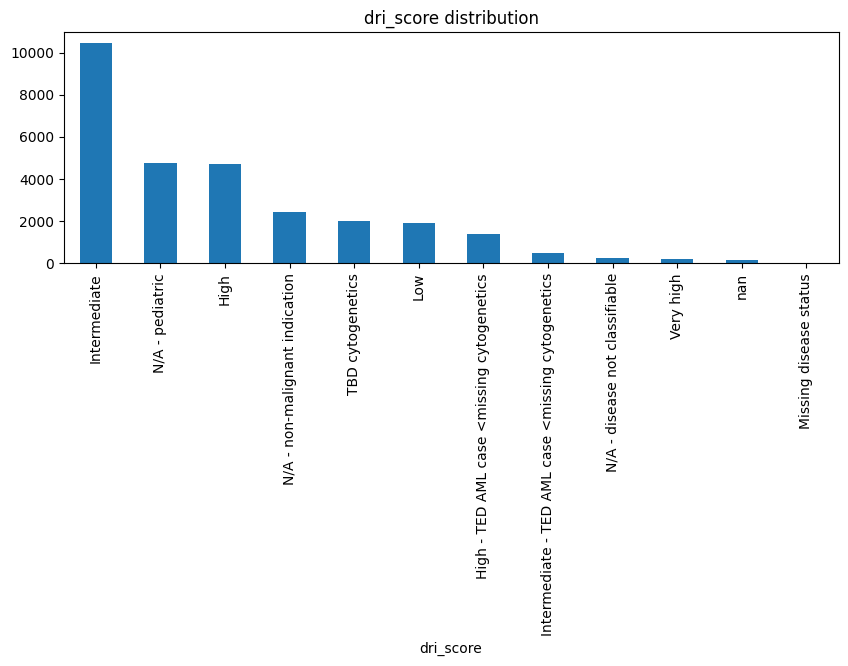

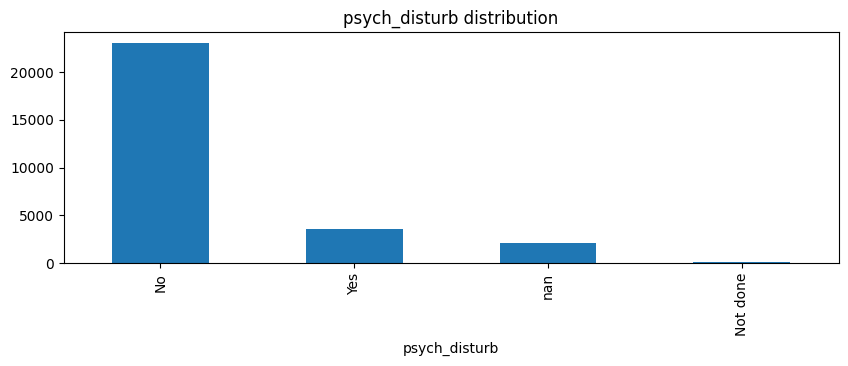

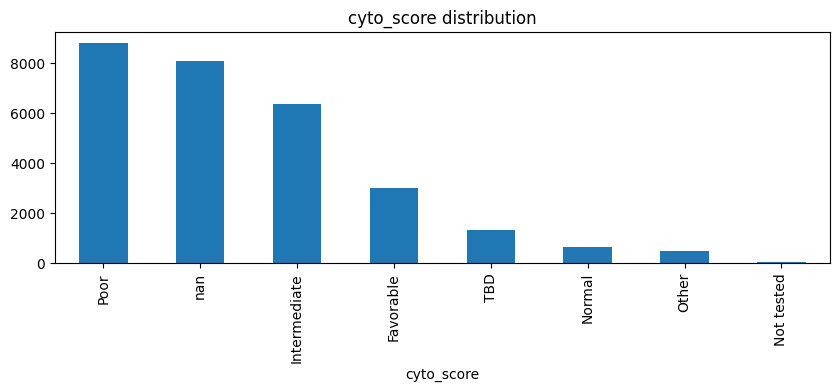

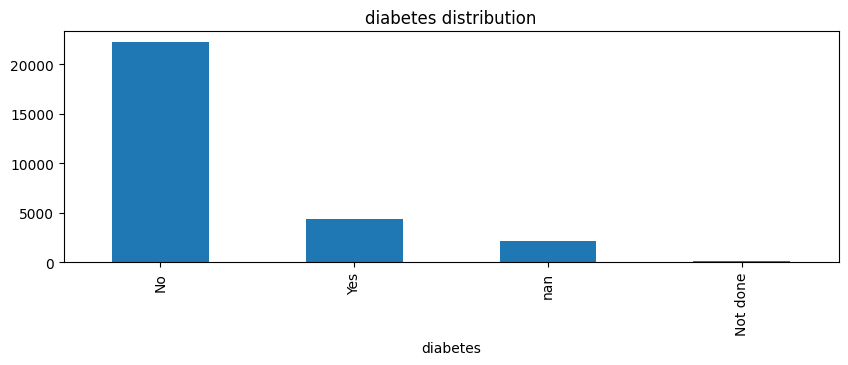

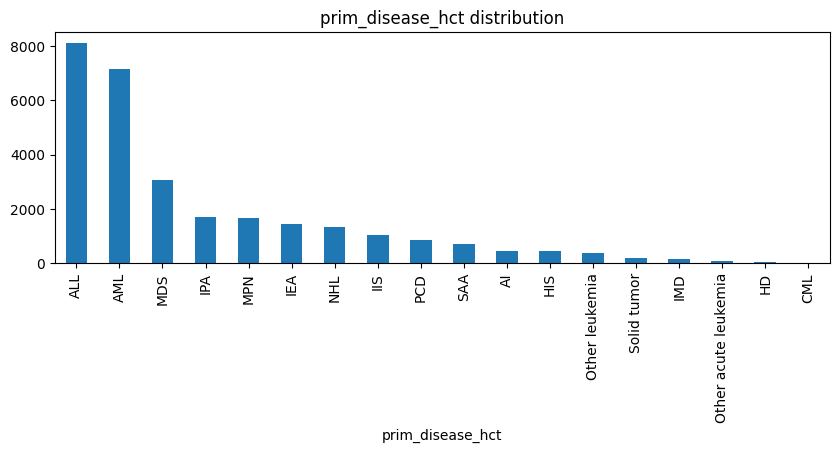

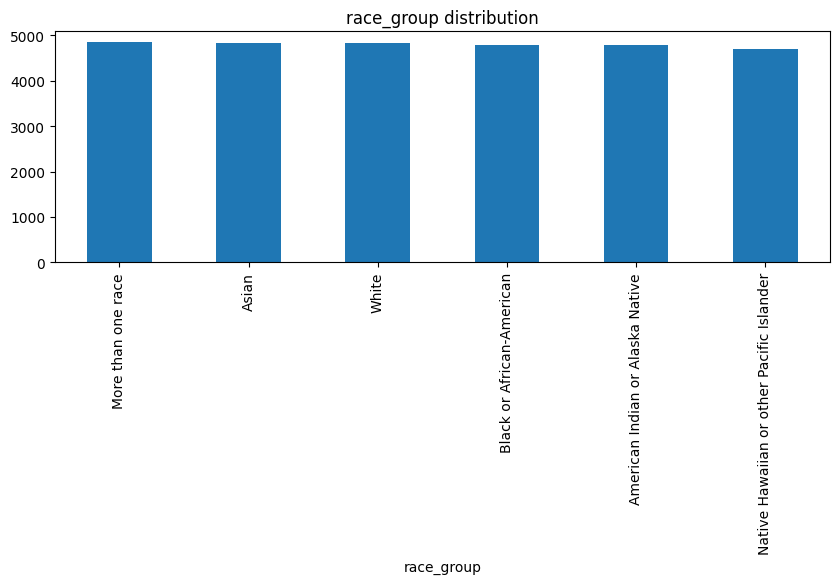

In [32]:
eda_selected_categoricals(train_df)

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


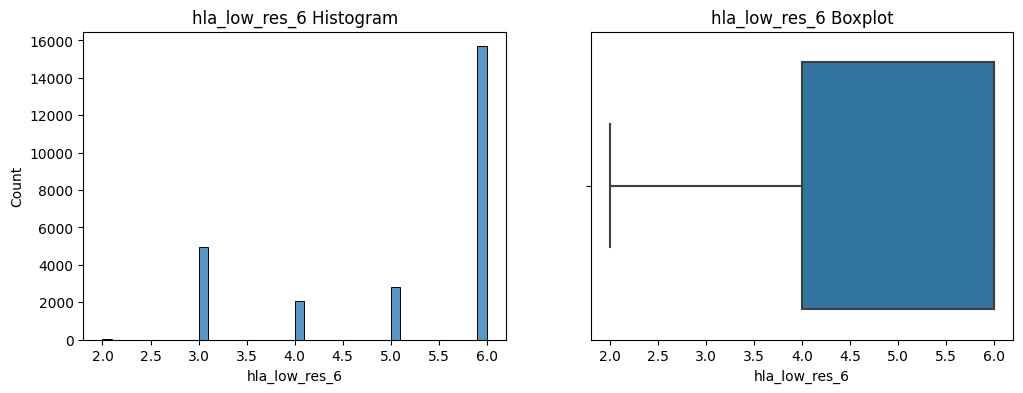

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


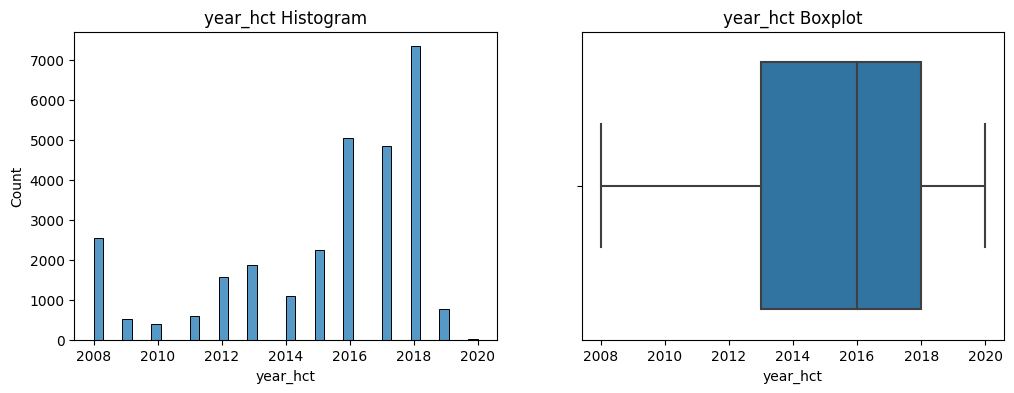

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


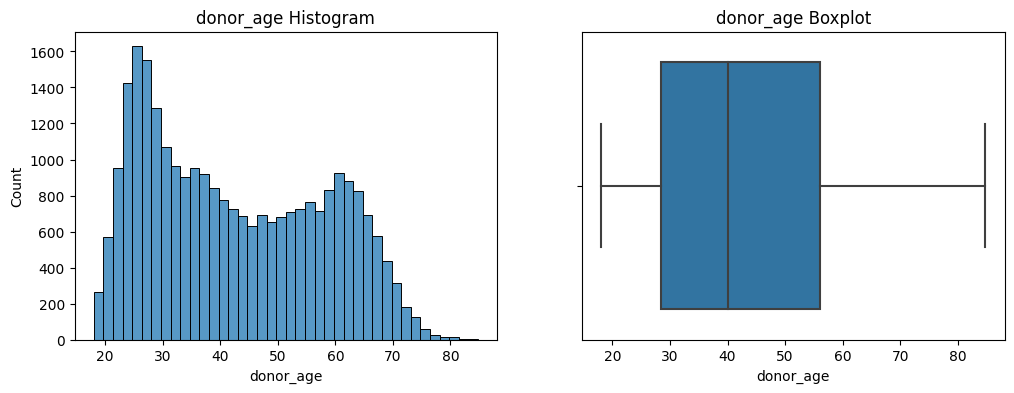

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


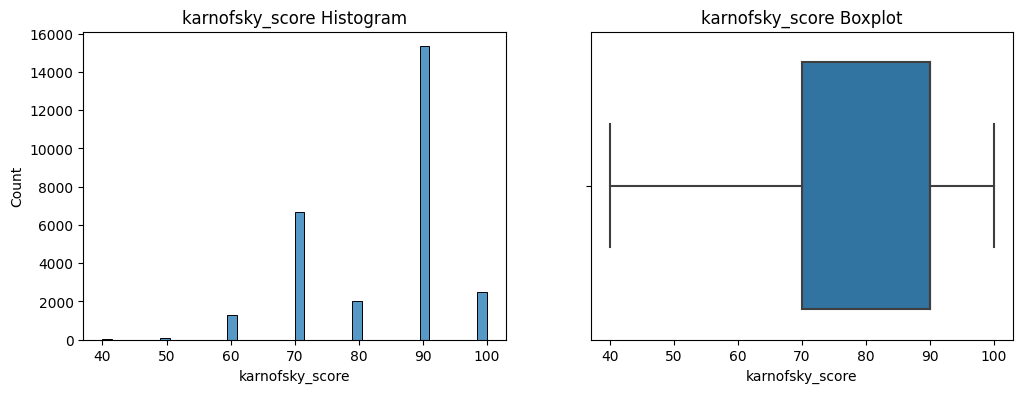

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


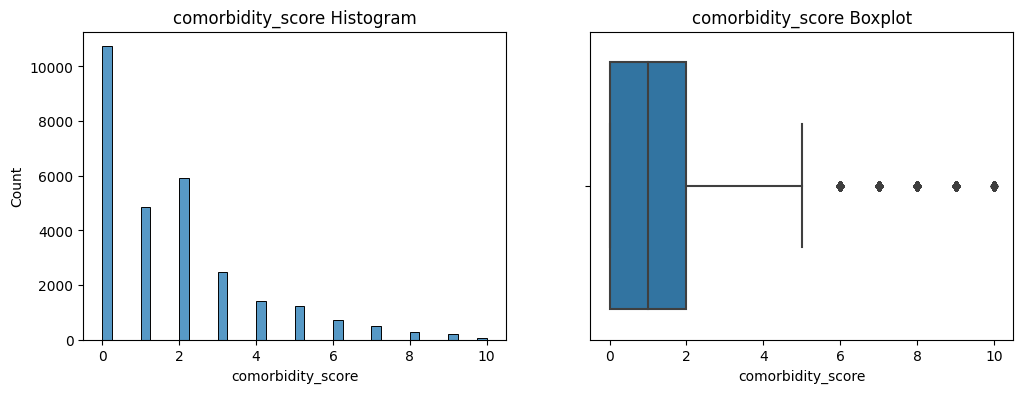

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


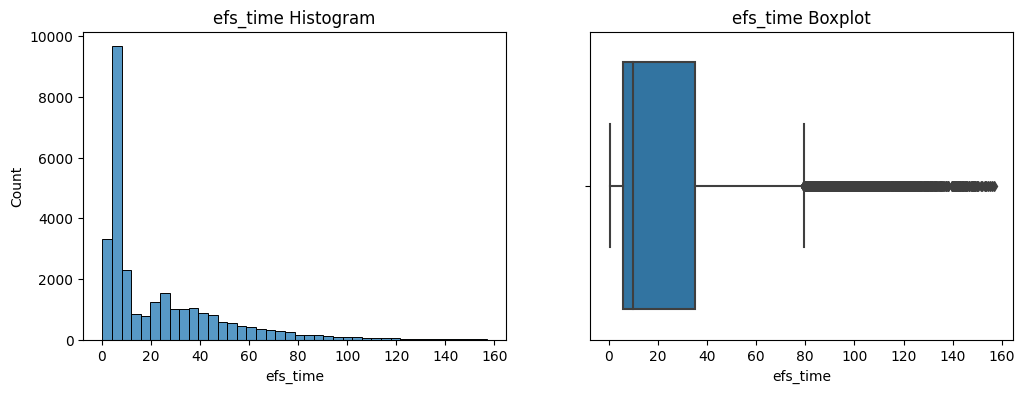

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


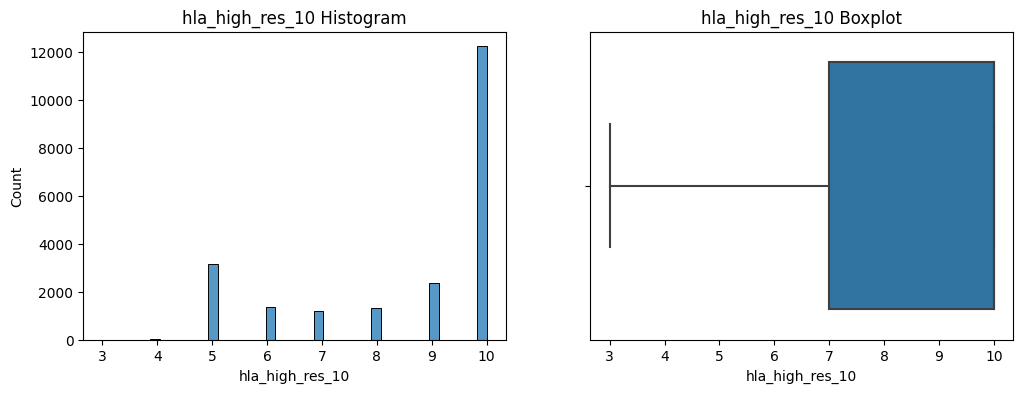

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


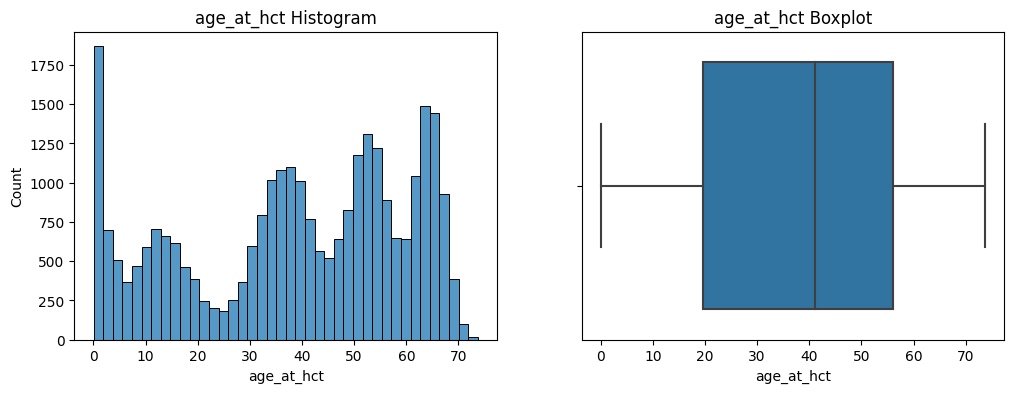

In [36]:
eda_selected_numeric(train_df)

From this data anlysis we can notice a few relevant points:
1. There are a lot of missing data
2. For categoical data we can see that there are binary fields but that have extra options such as "Not done"
3. For categorical fields, there are some that have a lot of posible values and there is an imbalance in the distrbution of these values
4. For numerical data, the fields of type "hla_X" are actually categorical, despite being marked as numeric
5. For numerical data there are fields where the distribution is skewed and there are outliers

/tmp/ipykernel_38/1175890769.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  missing_stats = train_df.groupby("race_group").apply(lambda x: x["comorbidity_score"].isna().mean()).sort_values()


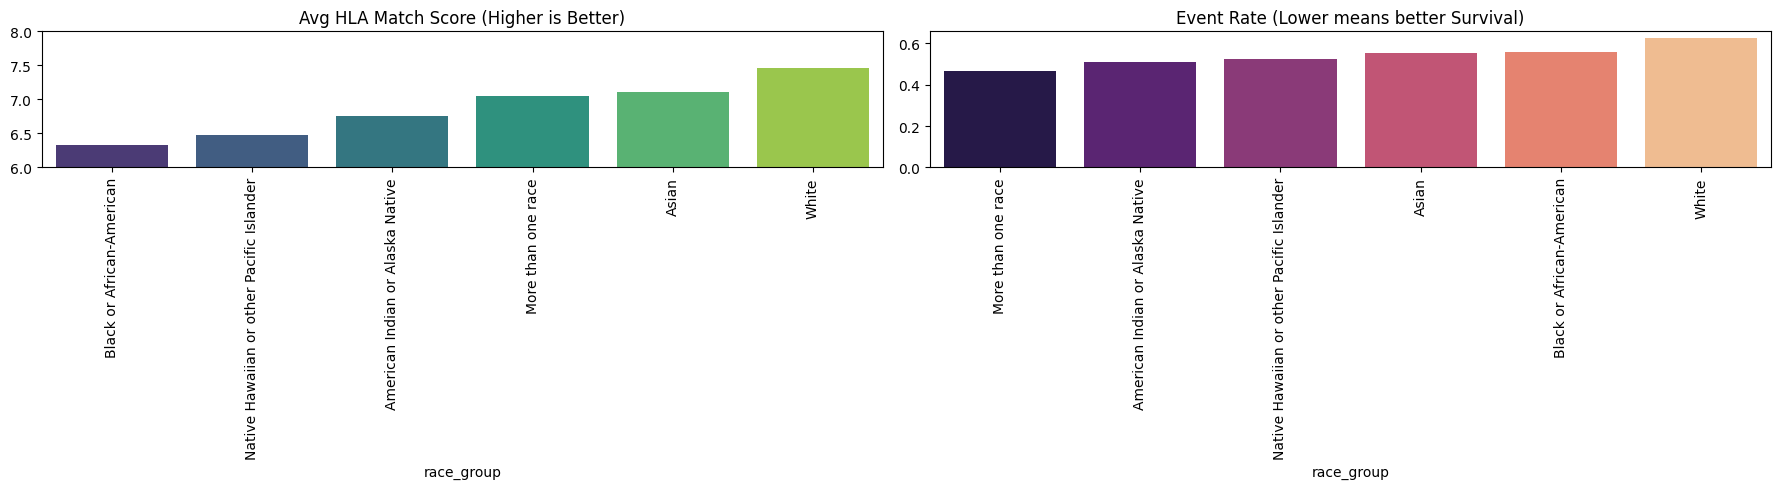

efs                                              0.0        1.0
race_group                                                     
White                                      37.445663  62.554337
Black or African-American                  44.129301  55.870699
Asian                                      44.846854  55.153146
Native Hawaiian or other Pacific Islander  47.652433  52.347567
American Indian or Alaska Native           48.956159  51.043841
More than one race                         53.415893  46.584107


In [67]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# HLA Match Quality by Race
hla_stats = train_df.groupby("race_group")["hla_high_res_8"].mean().sort_values()

# Event Rate by Race
# Is one group dying much more often?
event_stats = train_df.groupby("race_group")["efs"].mean().sort_values()

# Missingness by Race
# Let's check a complex field like 'comorbidity_score'
missing_stats = train_df.groupby("race_group").apply(lambda x: x["comorbidity_score"].isna().mean()).sort_values()

fig, axes = plt.subplots(1, 2, figsize=(18, 5))

sns.barplot(x=hla_stats.index, y=hla_stats.values, ax=axes[0], palette="viridis")
axes[0].set_title("Avg HLA Match Score (Higher is Better)")
axes[0].set_ylim(6, 8)
axes[0].tick_params(axis='x', rotation=90)

sns.barplot(x=event_stats.index, y=event_stats.values, ax=axes[1], palette="magma")
axes[1].set_title("Event Rate (Lower means better Survival)")
axes[1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()


# EFS Percentage (Target Balance)
efs_counts = train_df.groupby(["race_group", "efs"]).size().unstack(fill_value=0)
efs_pct = efs_counts.div(efs_counts.sum(axis=1), axis=0) * 100
efs_pct = efs_pct.sort_values(by=1, ascending=False)

print(efs_pct)

We can notice a contradiction between Biology and Statistics:

Biology: "White" patients have the Best HLA matches (7.5/8). "Native Hawaiian" and "Black" have the Worst (6.3/8). Biologically, minorities should be higher risk.

Statistics: "White" patients have the Highest Event Rate (62.5%). "More than one race" has the lowest event rate (46.5%).

This way we get the following bias:

The model learns that White patients fail often (62% base rate). It plays it safe and predicts "High Risk" for most of them. Result: high recall (0.86).

The model learns that "More than one race" patients usually survive (only 46% events). It plays it safe and predicts "Low Risk" for most of them. Because the model assumes "More than one race" patients are safe, it misses the ones who are actually in danger. This is why the recall for that group is only 0.65.

Conclusion: The model isn't "biased against" minorities in the traditional sense; it is biased towards the majority base rate. It is over-optimistic about minority survival because statistically, in this specific training set, they survive more often.

# [Step 3] Data Preporcessing

In [6]:
# Load Data
data_dict = pd.read_csv('/kaggle/input/equity-post-HCT-survival-predictions/data_dictionary.csv')
train_df = pd.read_csv('/kaggle/input/equity-post-HCT-survival-predictions/train.csv')

In [7]:
# Clean Binary Flags
# For fields that would normally be binary but have extra values such as "Not done"
# to remove ambiguity, and to make it easier for the models to deal with such data
# Convert "Not done", "NaN", "No" -> 0, "Yes" -> 1
binary_clean_cols = [
    'vent_hist', 'arrhythmia', 'diabetes', 'psych_disturb',
    'renal_issue', 'hepatic_severe', 'prior_tumor', 'peptic_ulcer',
    'rheum_issue', 'obesity', 'cardiac', 'pulm_severe'
]

for col in binary_clean_cols:
    train_df[col] = train_df[col].astype(str).apply(lambda x: 1 if 'Yes' in x else 0)

In [8]:
# Group Rare Categories (Long-Tail Handling)
# Categories with < 1% frequency are grouped into "Other_Rare"
# To reduce dimensionality, avoid overfitting
rare_cols = ['prim_disease_hct', 'tbi_status', 'tce_imm_match', 'dri_score', 'graft_type']

for col in rare_cols:
    counts = train_df[col].value_counts(normalize=True)
    rare_cats = counts[counts < 0.01].index
    if len(rare_cats) > 0:
        train_df.loc[train_df[col].isin(rare_cats), col] = "Other_Rare"

In [9]:
# Compute median and 99th percentile only on non-missing values
median = train_df['comorbidity_score'].median()
upper = train_df['comorbidity_score'].quantile(0.99)

# Fill NaNs with the median, then clip outliers
train_df['comorbidity_score'] = (
    train_df['comorbidity_score']
        .fillna(median)
        .clip(upper=upper)
)


In [10]:
# Convert HLA match counts into mismatch counts.
# HLA = Human Leukocyte Antigen system
# In HCT biology, higher HLA mismatches strongly correlate with worse outcomes
# (e.g., increased GVHD risk and lower survival).
# Models learn this risk relationship more easily when expressed as mismatches
# because higher values directly indicate higher immunological risk.
# Missing match values are treated as worst-case (full mismatch).
train_df['mismatch_8'] = 8 - pd.to_numeric(train_df['hla_high_res_8'], errors='coerce').fillna(8)
train_df['mismatch_10'] = 10 - pd.to_numeric(train_df['hla_high_res_10'], errors='coerce').fillna(10)

for gene in ['a', 'b', 'c', 'drb1', 'dqb1']:
    col_name = f'hla_match_{gene}_high'
    # 2 is perfect, so (2 - val) is mismatch count
    train_df[f'mismatch_{gene}'] = 2 - pd.to_numeric(train_df[col_name], errors='coerce').fillna(2)
        

In [11]:
# Age Interactions
# Age difference between donor and recipient may affect transplant risk.
# Missing donor ages are filled with the median to avoid bias.
median_age = train_df['donor_age'].median()
train_df['age_diff'] = train_df['age_at_hct'] - train_df['donor_age'].fillna(median_age)
train_df['donor_age_sq'] = train_df['donor_age'].fillna(median_age) ** 2

In [12]:
# Conditioning intensity interactions:
# MAC regimens are highly toxic and carry greater risk,
# especially for older patients and those with high comorbidity.
# Create a binary indicator for MAC, then interact it with age and comorbidities
# to capture clinically known high-risk combinations.

def is_high_intensity(val):
    return 1 if str(val) == 'MAC' else 0

train_df['is_mac'] = train_df['conditioning_intensity'].apply(is_high_intensity)

# Age x Intensity (Older patients die on MAC)
train_df['mac_x_age'] = train_df['is_mac'] * train_df['age_at_hct']

# Comorbidity x Intensity (Sick patients die on MAC)

train_df['mac_x_comorbidity'] = train_df['is_mac'] * train_df['comorbidity_score']


In [13]:
# Build final lists of categorical and numeric features by updating the data dictionary,
# adding engineered features, converting cleaned binaries to numeric, and removing ID/target columns.
categorical_vars = data_dict.loc[data_dict["type"] == "Categorical", "variable"].tolist()
numeric_vars      = data_dict.loc[data_dict["type"] == "Continuous", "variable"].tolist()

# 1. Handle manually converted binary columns
for col in binary_clean_cols:
    if col in categorical_vars: categorical_vars.remove(col)
    if col not in numeric_vars: numeric_vars.append(col)

# 2. Add Engineered Features to numeric list
new_feats = [
    'mismatch_8', 'mismatch_10',
    'mismatch_a', 'mismatch_b', 'mismatch_c', 'mismatch_drb1', 'mismatch_dqb1',
    'age_diff', 'donor_age_sq',
    'is_mac', 'mac_x_age', 'mac_x_comorbidity',
    'disease_risk_score'
]
numeric_vars.extend([f for f in new_feats if f in train_df.columns])

# 3. Rremove target/ID
for bad in ["efs", "efs_time", "ID"]:
    if bad in categorical_vars: categorical_vars.remove(bad)
    if bad in numeric_vars: numeric_vars.remove(bad)


In [14]:
# Split the data
train_idx, val_idx = train_test_split(
    train_df.index,
    test_size=0.3,
    stratify=train_df["efs"],
    random_state=42
)

In [15]:
# Target encoding for prim_disease_hct:
# Compute mean EFS per disease using TRAIN ONLY (prevents leakage),
# then map these risk values onto train and val. Unseen categories use global mean.

disease_map = train_df.loc[train_idx].groupby("prim_disease_hct")["efs"].mean()
global_mean = train_df.loc[train_idx, "efs"].mean()

train_df.loc[train_idx, "disease_risk_score"] = train_df.loc[train_idx, "prim_disease_hct"].map(disease_map).fillna(global_mean)
train_df.loc[val_idx, "disease_risk_score"] = train_df.loc[val_idx, "prim_disease_hct"].map(disease_map).fillna(global_mean)

In [16]:
# Dealing with missing values
for col in categorical_vars:
    if col in train_df.columns:
        train_df[col] = train_df[col].fillna("Unknown").astype(str)

# Missing values can also be informative
# This is posible because there isn't a big number of numerical fields left
for col in numeric_vars:
    if col in train_df.columns:
        train_df[f"{col}_missing"] = train_df[col].isna().astype(int)
        med = train_df.loc[train_idx, col].median()
        train_df[col] = train_df[col].fillna(med)

indicator_cols = [c for c in train_df.columns if c.endswith("_missing")]
all_feature_cols = categorical_vars + numeric_vars + indicator_cols

In [17]:
# Standardize data
X_train = train_df.loc[train_idx, all_feature_cols]
y_train = train_df.loc[train_idx, "efs"]
X_val = train_df.loc[val_idx, all_feature_cols]
y_val = train_df.loc[val_idx, "efs"]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_vars),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_vars),
    ],
    remainder="passthrough"
)

X_train_pre = preprocessor.fit_transform(X_train)
X_val_pre = preprocessor.transform(X_val)


# [Step 4] Evaluation

In [18]:

def competition_score(y_true_df, risk_scores, row_id_column="ID"):
    """
    y_true_df must contain columns:
        ID, efs, efs_time, race_group
    risk_scores: numpy array aligned with y_true_df rows
    """

    df = y_true_df.copy()
    df = df[[row_id_column, "efs", "efs_time", "race_group"]].copy()

    sub = pd.DataFrame({
        row_id_column: df[row_id_column].values,
        "prediction": risk_scores
    })

    merged = pd.concat([df.reset_index(drop=True),
                        sub["prediction"]], axis=1)

    group_scores = []
    for race, g in merged.groupby("race_group"):
        cidx = concordance_index(
            g["efs_time"].values,
            -g["prediction"].values,
            g["efs"].values
        )
        group_scores.append(cidx)

    group_scores = np.array(group_scores)

    return float(group_scores.mean() - np.sqrt(group_scores.var()))


In [133]:
def evaluate_risk_model(
    name,
    risk_scores,
    y_true_df,
    score_func=competition_score,
    verbose=True
):
    y_true = y_true_df["efs"].values

    auc = roc_auc_score(y_true, risk_scores)

    thr = np.median(risk_scores)
    preds = (risk_scores >= thr).astype(int)

    acc = accuracy_score(y_true, preds)
    prec = precision_score(y_true, preds)
    rec = recall_score(y_true, preds)
    f1 = f1_score(y_true, preds)
    cm = confusion_matrix(y_true, preds)

    comp_score = score_func(y_true_df, risk_scores)

    if verbose:
        print(f"\n=== {name} PERFORMANCE ===")
        print("AUC:", auc)
        print(f"Median Threshold: {thr:.5f}")
        print(f"Accuracy: {acc:.4f}")
        print(f"Precision: {prec:.4f}")
        print(f"Recall: {rec:.4f}")
        print(f"F1: {f1:.4f}")
        print("Confusion:\n", cm)
        print("C-Score:", comp_score)

    return {
        "Name": name,
        "AUC": auc,
        "Threshold": thr,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1": f1,
        "Confusion Matrix": cm,
        "C-Score": comp_score,
        "Preds": preds
    }


# [Step 5] Logistic Regression

In [125]:
def train_logistic_model(
    X_train, y_train, X_val,
    C=1.0,
    max_iter=100,
    pos_weight=None,
    class_weight=None,
    solver="lbfgs",
    random_state=42
):

    if class_weight is not None:
        cw = class_weight
    elif pos_weight is not None:
        cw = {0: 1.0, 1: pos_weight}
    else:
        cw = None

    model = LogisticRegression(
        C=C,
        max_iter=max_iter,
        solver=solver,
        class_weight=cw,
        random_state=random_state
    )

    model.fit(X_train, y_train)
    risk = model.predict_proba(X_val)[:, 1]
    
    return model, risk


In [135]:
log_reg, y_val_pred = train_logistic_model(
    X_train_pre, y_train, X_val_pre,
    max_iter=2000,
    class_weight="balanced",
    solver="lbfgs"
)


In [134]:
results_log = evaluate_risk_model(
    name="Logistic Regression",
    risk_scores=y_val_pred,
    y_true_df=y_val_df 
)



=== Logistic Regression PERFORMANCE ===
AUC: 0.743244495007225
Median Threshold: 0.53001
Accuracy: 0.6704
Precision: 0.7097
Recall: 0.6579
F1: 0.6829
Confusion:
 [[2726 1254]
 [1594 3066]]
C-Score: 0.6478592859268747


# [Step 6] DeepSurv

In [139]:
# Cox partial likelihood loss for survival modeling:
# Used because standard classification losses cannot handle censored data.
# This loss compares each event to the risk of all patients still at risk at that time,
# allowing the network to learn relative hazard (risk) in a statistically correct way.

def cox_ph_loss(risk, time, event):
    # sort by time descending
    order = torch.argsort(time, descending=True)
    risk = risk[order]
    event = event[order]

    # cumulative sum of exp(risk)
    hazard_ratio = torch.exp(risk)
    log_risk_sum = torch.log(torch.cumsum(hazard_ratio, dim=0))

    # select only uncensored events
    uncensored_likelihood = risk - log_risk_sum
    loss = -torch.sum(uncensored_likelihood * event) / torch.sum(event)
    return loss


In [140]:
def build_deepsurv(input_dim, params, device):
    layers = []
    curr_dim = input_dim

    for _ in range(params["n_layers"]):
        layers.extend([
            nn.Linear(curr_dim, params["hidden_dim"]),
            nn.ReLU(),
            nn.Dropout(params["dropout"])
        ])
        curr_dim = params["hidden_dim"]

    layers.append(nn.Linear(curr_dim, 1)) 

    return nn.Sequential(*layers).to(device)


In [141]:
def train_deepsurv(
    model,
    X_train_t, time_train, event_train,
    X_val_t, time_val_t, event_val_t,
    params
):

    opt = optim.AdamW(
        model.parameters(),
        lr=params["lr"],
        weight_decay=params["weight_decay"]
    )

    max_epochs = params.get("max_epochs", 1000)
    patience = params.get("patience", 50)

    best_loss = float("inf")
    best_state = None
    epochs_no_improve = 0

    for epoch in range(max_epochs):

        # Training
        model.train()
        opt.zero_grad()
        pred = model(X_train_t).squeeze()
        loss = cox_ph_loss(pred, time_train, event_train)
        loss.backward()
        opt.step()

        # Validation
        model.eval()
        with torch.no_grad():
            val_pred = model(X_val_t).squeeze()
            val_loss = cox_ph_loss(val_pred, time_val_t, event_val_t).item()

        # Early stopping
        if val_loss < best_loss:
            best_loss = val_loss
            epochs_no_improve = 0
            best_state = {
                "model": copy.deepcopy(model.state_dict()),
                "opt": copy.deepcopy(opt.state_dict())
            }
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch+1}, best val loss={best_loss:.4f}")
            break

    model.load_state_dict(best_state["model"])
    opt.load_state_dict(best_state["opt"])

    return model


In [142]:
def predict_deepsurv(model, X_val_t):
    model.eval()
    with torch.no_grad():
        return model(X_val_t).squeeze().cpu().numpy()


In [150]:
X_train_t = torch.tensor(X_train_pre, dtype=torch.float32).to(device)
X_val_t = torch.tensor(X_val_pre, dtype=torch.float32).to(device)

time_train = torch.tensor(train_df.loc[X_train.index, "efs_time"].values, dtype=torch.float32).to(device)
event_train = torch.tensor(train_df.loc[X_train.index, "efs"].values, dtype=torch.float32).to(device)

time_val = torch.tensor(train_df.loc[X_val.index, "efs_time"].values, dtype=torch.float32).to(device)
event_val = torch.tensor(train_df.loc[X_val.index, "efs"].values, dtype=torch.float32).to(device)


In [158]:
params = {
    "n_layers": 2,
    "hidden_dim": 64,    
    "dropout": 0.2,   
    "lr": 1e-3,
    "weight_decay": 1e-4,
    "max_epochs": 200,
    "patience": 20
}


In [159]:
model_ds = build_deepsurv(
    input_dim=X_train_pre.shape[1],
    params=params,
    device=device
)

In [160]:
model_ds = train_deepsurv(
    model_ds,
    X_train_t, time_train, event_train,
    X_val_t, time_val, event_val,
    params
)

Early stopping at epoch 98, best val loss=8.5412


In [161]:
deep_risk = predict_deepsurv(model_ds, X_val_t)

y_val_df = train_df.loc[X_val.index, ["ID", "efs", "efs_time", "race_group"]]
results_deepsurv = evaluate_risk_model("DeepSurv", deep_risk, y_val_df)


=== DeepSurv PERFORMANCE ===
AUC: 0.7316892941100352
Median Threshold: -0.24109
Accuracy: 0.6650
Precision: 0.7044
Recall: 0.6530
F1: 0.6777
Confusion:
 [[2703 1277]
 [1617 3043]]
C-Score: 0.6575449665452511


# [Step 7] Weighted XGBoost

In [164]:
def compute_boost_weights(train_df, train_idx, weak_groups):
    """
    Creates per-patient weights for weighted survival boosting.
    """
    weights = np.ones(len(train_idx))

    for i, idx in enumerate(train_idx):
        race = train_df.loc[idx, "race_group"]
        event = train_df.loc[idx, "efs"]

        if race in weak_groups:
            weights[i] = 10.0 if event == 1 else 1.0
        else:
            weights[i] = 1.0

    return weights


In [167]:
def train_weighted_boost(
    X_train_pre, y_train, train_df, train_idx,
    X_val_pre, y_val, val_idx,
    weights, xgb_params
):
    train_labels = np.where(
        y_train == 1,
        train_df.loc[train_idx, "efs_time"],
        -train_df.loc[train_idx, "efs_time"]
    )

    val_labels = np.where(
        y_val == 1,
        train_df.loc[val_idx, "efs_time"],
        -train_df.loc[val_idx, "efs_time"]
    )

    dtrain = xgb.DMatrix(X_train_pre, label=train_labels, weight=weights)
    dval = xgb.DMatrix(X_val_pre, label=val_labels)

    model = xgb.train(
        xgb_params,
        dtrain,
        num_boost_round=2000,
        evals=[(dval, "eval")],
        early_stopping_rounds=100,
        verbose_eval=100
    )

    return model


In [165]:
def predict_weighted_boost(model, X_val_pre):
    dval = xgb.DMatrix(X_val_pre)
    return model.predict(dval)


In [168]:
weak_group_results = [
    "More than one race",
    "Native Hawaiian or other Pacific Islander",
    "American Indian or Alaska Native"
]

train_weights = compute_boost_weights(train_df, train_idx, weak_group_results)
print("Max weight:", train_weights.max())

boost_params = {
    "objective": "survival:cox",
    "eval_metric": "cox-nloglik",
    "tree_method": "hist",
    "device": "cuda",
    "learning_rate": 0.03,
    "max_depth": 4,
    "reg_alpha": 2.0,
    "subsample": 0.8,
    "seed": 42
}

model_boost = train_weighted_boost(
    X_train_pre=X_train_pre,
    y_train=y_train,
    train_df=train_df,
    train_idx=train_idx,
    X_val_pre=X_val_pre,
    y_val=y_val,
    val_idx=val_idx,
    weights=train_weights,
    xgb_params=boost_params
)

risk_boost = predict_weighted_boost(model_boost, X_val_pre)

y_val_df = train_df.loc[val_idx, ["ID", "efs", "efs_time", "race_group"]]

results_weighted_boost = evaluate_risk_model(
    name="Weighted Boost",
    risk_scores=risk_boost,
    y_true_df=y_val_df
)


Max weight: 10.0
[0]	eval-cox-nloglik:8.71329
[100]	eval-cox-nloglik:8.69443
[146]	eval-cox-nloglik:8.69932

=== Weighted Boost PERFORMANCE ===
AUC: 0.5920408372333772
Median Threshold: 104.58888
Accuracy: 0.5597
Precision: 0.5991
Recall: 0.5554
F1: 0.5764
Confusion:
 [[2248 1732]
 [2072 2588]]
C-Score: 0.6354516579369485


# [Step 8] Fine-tunning

## Logistic Regression

In [ ]:
param_grid_logreg = {
    "C": [0.01, 0.05, 0.07, 0.1, 0.2],
    "max_iter": [1000, 1500, 1700, 2000],
    "pos_weight": [0.3, 0.5, 0.7]
}

best_score = -float("inf")
best_params = None

y_val_df_tune = train_df.loc[val_idx, ["ID", "efs", "efs_time", "race_group"]]

for C in param_grid_logreg["C"]:
    for max_iter in param_grid_logreg["max_iter"]:
        for pos_weight in param_grid_logreg["pos_weight"]:

            print(f"Testing Logistic Regression: "
                  f"C={C}, max_iter={max_iter}, pos_weight={pos_weight}")

            model, val_risk = train_logistic_model(
                X_train_pre, y_train, X_val_pre,
                C=C,
                max_iter=max_iter,
                pos_weight=pos_weight
            )

            score = competition_score(y_val_df_tune, val_risk)

            print("Score:", score)

            if score > best_score:
                best_score = score
                best_params = {
                    "C": C,
                    "max_iter": max_iter,
                    "pos_weight": pos_weight
                }
                print(">> New Best:", best_score, best_params)


In [112]:
print("Best score:", best_score)
best_log_params = best_params
print("\nBest Logistic Params:", best_log_params)

Best score: 0.6487049542280392

Best Logistic Params: {'C': 0.1, 'max_iter': 1000, 'pos_weight': 0.3}


## DeepSurv

In [ ]:
param_grid = {
    "n_layers": [1, 2],                         
    "hidden_dim": [64, 128],                 
    "dropout": [0.3, 0.4, 0.5],               
    "lr": [5e-4, 6e-4, 1e-3],                
    "weight_decay": [0.001, 0.003, 0.005],   
    "max_epochs": [500, 750, 900],            
    "patience": [40, 60, 80]               
}

best_score = -float("inf")
best_params = None

y_val_df_tune = train_df.loc[val_idx, ["ID", "efs", "efs_time", "race_group"]]

for n_layers in param_grid["n_layers"]:
    for hidden_dim in param_grid["hidden_dim"]:
        for dropout in param_grid["dropout"]:
            for lr in param_grid["lr"]:
                for weight_decay in param_grid["weight_decay"]:
                    for max_epochs in param_grid["max_epochs"]:
                        for patience in param_grid["patience"]:

                            params = {
                                "n_layers": n_layers,
                                "hidden_dim": hidden_dim,
                                "dropout": dropout,
                                "lr": lr,
                                "weight_decay": weight_decay,
                                "max_epochs": max_epochs,
                                "patience": patience
                            }

                            print(
                                f"Testing DeepSurv: layers={n_layers}, "
                                f"dim={hidden_dim}, dropout={dropout}, lr={lr}, "
                                f"wd={weight_decay}, epochs={max_epochs}, patience={patience}"
                            )

                            model = build_deepsurv(
                                input_dim=X_train_pre.shape[1],
                                params=params,
                                device=device
                            )

                            model = train_deepsurv(
                                model,
                                X_train_t, time_train, event_train,
                                X_val_t, time_val_t, event_val_t,
                                params
                            )

                            val_risk = predict_deepsurv(model, X_val_t)

                            score = competition_score(y_val_df_tune, val_risk)
                            print("Score:", score)

                            if score > best_score:
                                best_score = score
                                best_params = params.copy()
                                print(">> New Best:", best_score, best_params)



In [108]:
print("Best score:", best_score)
best_ds_params = best_params

print("\nBest DeepSurv Params:")
print(best_ds_params)

Best score: 0.6602905903754188

Best DeepSurv Params:
{'n_layers': 1, 'hidden_dim': 64, 'dropout': 0.5, 'lr': 0.0005, 'weight_decay': 0.001, 'max_epochs': 500, 'patience': 60}


## Weighted XGBoost

In [180]:
def compute_DMatrices(train_df, train_idx, X_train_pre, X_val_pre, y_train, y_val):
    weak_group_results = [
        "More than one race",
        "Native Hawaiian or other Pacific Islander",
        "American Indian or Alaska Native"
    ]
    train_weights = compute_boost_weights(train_df, train_idx, weak_group_results)

    dtrain = xgb.DMatrix(
        X_train_pre,
        label=np.where(y_train==1,
                       train_df.loc[train_idx, "efs_time"],
                       -train_df.loc[train_idx, "efs_time"]),
        weight=train_weights
    )

    dval = xgb.DMatrix(
        X_val_pre,
        label=np.where(y_val==1,
                       train_df.loc[val_idx, "efs_time"],
                       -train_df.loc[val_idx, "efs_time"])
    )

    return dtrain, dval

In [179]:
param_grid_xgb = {
    "learning_rate": [0.06, 0.07],
    "max_depth": [3, 4],
    "grow_policy": ["lossguide"],
    "max_leaves": [50, 90],
    "gamma": [4, 6],
    "min_split_loss": [4, 6],
    "reg_alpha": [8, 10],
    "reg_lambda": [9, 12],
    "subsample": [0.5],
    "colsample_bytree": [0.6, 0.7],
    "min_child_weight": [4, 6],
    "num_parallel_tree": [2, 4]
}

In [ ]:
best_score = -float("inf")
best_params = None

y_val_df_tune = train_df.loc[val_idx, ["ID", "efs", "efs_time", "race_group"]]
dtrain, dval = compute_DMatrices(train_df, train_idx, X_train_pre, X_val_pre, y_train, y_val)

for lr in param_grid_xgb["learning_rate"]:
    for max_depth in param_grid_xgb["max_depth"]:
        for grow_policy in param_grid_xgb["grow_policy"]:
            for max_leaves in param_grid_xgb["max_leaves"]:
                for gamma in param_grid_xgb["gamma"]:
                    for min_split_loss in param_grid_xgb["min_split_loss"]:
                        for reg_alpha in param_grid_xgb["reg_alpha"]:
                            for reg_lambda in param_grid_xgb["reg_lambda"]:
                                for subsample in param_grid_xgb["subsample"]:
                                    for colsample in param_grid_xgb["colsample_bytree"]:
                                        for min_child_weight in param_grid_xgb["min_child_weight"]:
                                            for num_parallel_tree in param_grid_xgb["num_parallel_tree"]:

                                                params = {
                                                    "objective": "survival:cox",
                                                    "eval_metric": "cox-nloglik",
                                                    "tree_method": "hist",
                                                    "device": "cuda",

                                                    "learning_rate": lr,
                                                    "max_depth": max_depth,
                                                    "grow_policy": grow_policy,
                                                    "max_leaves": max_leaves,

                                                    "gamma": gamma,
                                                    "min_split_loss": min_split_loss,

                                                    "reg_alpha": reg_alpha,
                                                    "reg_lambda": reg_lambda,

                                                    "subsample": subsample,
                                                    "colsample_bytree": colsample,

                                                    "min_child_weight": min_child_weight,
                                                    "num_parallel_tree": num_parallel_tree,

                                                    "seed": 42
                                                }

                                                print("Testing params:", params)

                                                model = xgb.train(
                                                    params,
                                                    dtrain,
                                                    num_boost_round=3000,
                                                    evals=[(dval, "eval")],
                                                    early_stopping_rounds=200,
                                                    verbose_eval=False
                                                )

                                                preds = predict_weighted_boost(model, X_val_pre)

                                                score = competition_score(y_val_df_tune, preds)
                                                print("Score:", score)

                                                if score > best_score:
                                                    best_score = score
                                                    best_params = params.copy()
                                                    print(">> New Best:", best_score)
                                                    print(best_params)



In [122]:
print("Best score:", best_score)
best_xgboost_params = best_params
print("\nBest XGBoost Params:", best_xqboost_params)


Best score: 0.6601809304618788

Best XGBoost Params: {'objective': 'survival:cox', 'eval_metric': 'cox-nloglik', 'tree_method': 'hist', 'device': 'cuda', 'learning_rate': 0.07, 'max_depth': 4, 'grow_policy': 'lossguide', 'max_leaves': 50, 'gamma': 4, 'min_split_loss': 6, 'reg_alpha': 10, 'reg_lambda': 12, 'subsample': 0.5, 'colsample_bytree': 0.6, 'min_child_weight': 4, 'num_parallel_tree': 4, 'seed': 42}


# [Step 9] Ensemble

To get the best result we will use all the three models:


1.   DeepSurv (0.657): Best overall performance, handles non-linear itneractions well, good at generalizing
2.   Logistic Regression (0.648): Best global AUC and usefull from a statistical point of view
3. Equity XGBoost (0.635): Specifically tuned (via weights) to fix the ranking of minority failures.

From now on the best parameters will be hardcoded with the best values I obtained in my trials to have consistent results

In [202]:
best_xgboost_params={
    'objective': 'survival:cox', 
    'eval_metric': 'cox-nloglik', 
    'tree_method': 'hist', 
    'device': 'cuda', 
    'learning_rate': 0.07, 
    'max_depth': 4, 
    'grow_policy': 'lossguide', 
    'max_leaves': 50, 'gamma': 4, 
    'min_split_loss': 6, 
    'reg_alpha': 10, 'reg_lambda': 12, 
    'subsample': 0.5, 
    'colsample_bytree': 0.6, 
    'min_child_weight': 4, 
    'num_parallel_tree': 4, 
    'seed': 42
}

weak_group_results = [
        "More than one race",
        "Native Hawaiian or other Pacific Islander",
        "American Indian or Alaska Native",
        "Asian"
    ]
train_weights = compute_boost_weights(train_df, train_idx, weak_group_results)

final_model_boost = train_weighted_boost(
    X_train_pre=X_train_pre,
    y_train=y_train,
    train_df=train_df,
    train_idx=train_idx,
    X_val_pre=X_val_pre,
    y_val=y_val,
    val_idx=val_idx,
    weights=train_weights,
    xgb_params=best_xgboost_params
)

risk_boost = predict_weighted_boost(final_model_boost, X_val_pre)

[0]	eval-cox-nloglik:8.70903
[100]	eval-cox-nloglik:8.67554
[199]	eval-cox-nloglik:8.67919


In [162]:
best_ds_params = {'n_layers': 1, 
 'hidden_dim': 64, 
 'dropout': 0.5, 
 'lr': 0.0005, 
 'weight_decay': 0.001, 
 'max_epochs': 500, 
 'patience': 60
}
X_val_t = torch.tensor(X_val_pre, dtype=torch.float32).to(device)
time_val_t = torch.tensor(time_val, dtype=torch.float32).to(device)
event_val_t = torch.tensor(event_val, dtype=torch.float32).to(device)

final_ds = build_deepsurv(
    input_dim=X_train_pre.shape[1],
    params=best_ds_params,
    device=device
)

final_ds = train_deepsurv(
    final_ds,
    X_train_t, time_train, event_train,
    X_val_t, time_val_t, event_val_t,
    best_ds_params
)

risk_ds = predict_deepsurv(final_ds, X_val_t)

/tmp/ipykernel_38/2476519948.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  time_val_t = torch.tensor(time_val, dtype=torch.float32).to(device)
/tmp/ipykernel_38/2476519948.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  event_val_t = torch.tensor(event_val, dtype=torch.float32).to(device)


Early stopping at epoch 381, best val loss=8.5395


In [138]:
best_log_params = {
    'C': 0.1, 
    'max_iter': 1000, 
    'pos_weight': 0.3}

final_log, risk_log = train_logistic_model(
    X_train_pre, y_train, X_val_pre,
    C=best_log_params["C"],
    max_iter=best_log_params["max_iter"],
    pos_weight=best_log_params["pos_weight"],
    solver="lbfgs"
)



In [203]:
r_ds  = rankdata(risk_ds)      / len(risk_ds)
r_xgb = rankdata(risk_boost)   / len(risk_boost)
r_log = rankdata(risk_log)     / len(risk_log)

risk_final = (0.40 * r_ds) + (0.40 * r_xgb) + (0.20 * r_log)

y_val_df = train_df.loc[val_idx, ["ID", "efs", "efs_time", "race_group"]]

results_final = evaluate_risk_model(
    name="Final Ensemble",
    risk_scores=risk_final,
    y_true_df=y_val_df
)

models = {
    "DeepSurv": risk_ds,
    "Logistic Reg": risk_log,
    "Weighted Boost": risk_boost
}

print(f"\n{'MODEL':<20} | {'C-SCORE':<10} | {'AUC':<6} | {'F1':<6} | {'ACC':<6}")
print("-" * 70)

results_all = {}

for name, risks in models.items():
    res = evaluate_risk_model(name, risks, y_val_df, verbose=False)
    results_all[name] = res

    print(
        f"{name:<20} | "
        f"{res['C-Score']:.5f}   | "
        f"{res['AUC']:.4f} | "
        f"{res['F1']:.4f} | "
        f"{res['Accuracy']:.4f}"
    )

print("\n=== FINAL ENSEMBLE SUMMARY ===")
print(f"Model:        {results_final['Name']}")
print(f"AUC:          {results_final['AUC']:.4f}")
print(f"C-Score:      {results_final['C-Score']:.5f}")
print(f"F1:           {results_final['F1']:.4f}")
print(f"Accuracy:     {results_final['Accuracy']:.4f}")
print(f"Threshold:    {results_final['Threshold']:.5f}")

print("\nConfusion Matrix:")
print(results_final["Confusion Matrix"])

preds_final  = results_final["Preds"]
thresh_final = results_final["Threshold"]



=== Final Ensemble PERFORMANCE ===
AUC: 0.7119408738973839
Median Threshold: 0.49670
Accuracy: 0.6514
Precision: 0.6907
Recall: 0.6403
F1: 0.6646
Confusion:
 [[2644 1336]
 [1676 2984]]
C-Score: 0.6616359291358802

MODEL                | C-SCORE    | AUC    | F1     | ACC   
----------------------------------------------------------------------
DeepSurv             | 0.65842   | 0.7318 | 0.6744 | 0.6616
Logistic Reg         | 0.64870   | 0.7446 | 0.6866 | 0.6743
Weighted Boost       | 0.64271   | 0.6046 | 0.5924 | 0.5764

=== FINAL ENSEMBLE SUMMARY ===
Model:        Final Ensemble
AUC:          0.7119
C-Score:      0.66164
F1:           0.6646
Accuracy:     0.6514
Threshold:    0.49670

Confusion Matrix:
[[2644 1336]
 [1676 2984]]
